In [2]:
import sys
sys.path.append("../../../../src")
import pandas
import random
import math
from energiapy.components.temporal_scale import TemporalScale
from energiapy.components.resource import Resource, VaryingResource
from energiapy.components.process import Process, VaryingProcess
from energiapy.components.location import Location
from energiapy.components.transport import Transport, VaryingTransport
from energiapy.components.network import Network
from energiapy.components.scenario import Scenario
from energiapy.model.constraints.demand import constraint_demand_lb
from energiapy.model.formulate import formulate, Constraints, Objective
from energiapy.plot import plot_results, plot_scenario
from energiapy.model.solve import solve
from pyomo.environ import value as pyo_val
from energiapy.utils.scale_utils import scale_tuple
import matplotlib.pyplot as plt
from matplotlib import rc
from typing import Union, Tuple, List
from pyomo.environ import ConcreteModel, Var, NonNegativeReals
import pickle
from pyomo.contrib.iis import write_iis
import pickle


In [2]:
schedule_time_intervals = 7  # Number of time intervals in a planning horizon
_coms = 1
design_exec_scenarios = 4  # Number of execution scenarios
schedule_exec_scenarios = 52

M = 1e4  # Big M
# Define temporal scales
# scales = TemporalScale(discretization_list=[_exec_scenarios, _time_intervals])
design_annualization_factor = 1/design_exec_scenarios
schedule_annualization_factor = 1

In [1]:
def build_schedule_model(start_time: tuple, end_time: tuple, scen_df=pandas.DataFrame(), eps: float = 1.0):
    default_df = pandas.DataFrame(data=[1] * schedule_exec_scenarios)
    scale_factor = 1
    multiplier = 10

    # Define temporal scales
    scales = TemporalScale(discretization_list=[1, schedule_exec_scenarios, schedule_time_intervals],
                           start_zero=start_time, end_zero=end_time)

    # ======================================================================================================================
    # Declare resources/commodities
    # ======================================================================================================================
    com1_pur = Resource(name='com1_pur', cons_max=500 * scale_factor, block={'imp': 1, 'urg': 1}, price=0.00,
                        label='Commodity 1 consumed from outside the system',
                        varying=[VaryingResource.DETERMINISTIC_AVAILABILITY])

    com1_in = Resource(name='com1_in', label='Commodity 1 received')
    com1_out = Resource(name='com1_out', label='Commodity 1 to be sent out')

    com1_loc1_out = Resource(name='com1_loc1_out', label='Commodity 1 sent out from location 1')
    com1_loc2_out = Resource(name='com1_loc2_out', label='Commodity 1 sent out from location 2')
    com1_loc3_out = Resource(name='com1_loc3_out', label='Commodity 1 sent out from location 3')
    com1_loc4_out = Resource(name='com1_loc4_out', label='Commodity 1 sent out from location 4')
    com1_loc5_out = Resource(name='com1_loc5_out', label='Commodity 1 sent out from location 5')
    com1_loc6_out = Resource(name='com1_loc6_out', label='Commodity 1 sent out from location 6')
    com1_loc7_out = Resource(name='com1_loc7_out', label='Commodity 1 sent out from location 7')

    com1_sold = Resource(name='com1_sold', revenue=0.00, demand=True, sell=True,
                         label='Commodity 1 sold to outside the system', varying=[VaryingResource.DETERMINISTIC_DEMAND])

    # ======================================================================================================================
    # Declare processes/storage capacities
    # ======================================================================================================================
    com1_process_capacity = 500 * scale_factor * multiplier
    min_process_capacity = 0.01

    com1_procure = Process(name='procure com1', prod_max=com1_process_capacity, conversion={com1_pur: -1, com1_in: 1},
                           capex=25 / scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Procure com1')
    com1_sell = Process(name='sell com1', prod_max=com1_process_capacity, conversion={com1_out: -1, com1_sold: 1},
                        capex=0.1 / scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Sell com1')

    com1_receive_loc1 = Process(name='com1_receive_loc1', prod_max=com1_process_capacity,
                                conversion={com1_loc1_out: -1, com1_in: 1}, capex=0.1 / scale_factor, vopex=0.01,
                                prod_min=min_process_capacity, label='Commodity 1 received from location 1')
    com1_receive_loc2 = Process(name='com1_receive_loc2', prod_max=com1_process_capacity,
                                conversion={com1_loc2_out: -1, com1_in: 1}, capex=0.1 / scale_factor, vopex=0.01,
                                prod_min=min_process_capacity, label='Commodity 1 received from location 2')
    com1_receive_loc3 = Process(name='com1_receive_loc3', prod_max=com1_process_capacity,
                                conversion={com1_loc3_out: -1, com1_in: 1}, capex=0.1 / scale_factor, vopex=0.01,
                                prod_min=min_process_capacity, label='Commodity 1 received from location 3')
    com1_receive_loc4 = Process(name='com1_receive_loc4', prod_max=com1_process_capacity,
                                conversion={com1_loc4_out: -1, com1_in: 1}, capex=0.1 / scale_factor, vopex=0.01,
                                prod_min=min_process_capacity, label='Commodity 1 received from location 4')
    com1_receive_loc5 = Process(name='com1_receive_loc5', prod_max=com1_process_capacity,
                                conversion={com1_loc5_out: -1, com1_in: 1}, capex=0.1 / scale_factor, vopex=0.01,
                                prod_min=min_process_capacity, label='Commodity 1 received from location 5')
    com1_receive_loc6 = Process(name='com1_receive_loc6', prod_max=com1_process_capacity,
                                conversion={com1_loc6_out: -1, com1_in: 1}, capex=0.1 / scale_factor, vopex=0.01,
                                prod_min=min_process_capacity, label='Commodity 1 received from location 6')
    com1_receive_loc7 = Process(name='com1_receive_loc7', prod_max=com1_process_capacity,
                                conversion={com1_loc7_out: -1, com1_in: 1}, capex=0.1 / scale_factor, vopex=0.01,
                                prod_min=min_process_capacity, label='Commodity 1 received from location 7')

    com1_process = Process(name='com1_process', prod_max=com1_process_capacity, conversion={com1_in: -1, com1_out: 1},
                           capex=5 / scale_factor, vopex=0.01, prod_min=min_process_capacity,
                           varying=[VaryingProcess.DETERMINISTIC_CAPACITY],
                           label='Process the commodity through the location')

    com1_store = Process(name='com1_store', prod_max=com1_process_capacity, capex=0.01 / scale_factor, vopex=5,
                         store_min=0.01, store_max=500 * scale_factor * multiplier, prod_min=min_process_capacity,
                         label="Storage capacity of upto 100 units", storage=com1_in, storage_cost=0.02,
                         storage_capex=50 / scale_factor)

    com1_loc1_send = Process(name='com1_loc1_send', prod_max=com1_process_capacity,
                             conversion={com1_out: -1, com1_loc1_out: 1}, capex=0.1 / scale_factor, vopex=0.01,
                             prod_min=min_process_capacity, label='Send commodity one from location 1')
    com1_loc2_send = Process(name='com1_loc2_send', prod_max=com1_process_capacity,
                             conversion={com1_out: -1, com1_loc2_out: 1}, capex=0.1 / scale_factor, vopex=0.01,
                             prod_min=min_process_capacity, label='Send commodity one from location 2')
    com1_loc3_send = Process(name='com1_loc3_send', prod_max=com1_process_capacity,
                             conversion={com1_out: -1, com1_loc3_out: 1}, capex=0.1 / scale_factor, vopex=0.01,
                             prod_min=min_process_capacity, label='Send commodity one from location 3')
    com1_loc4_send = Process(name='com1_loc4_send', prod_max=com1_process_capacity,
                             conversion={com1_out: -1, com1_loc4_out: 1}, capex=0.1 / scale_factor, vopex=0.01,
                             prod_min=min_process_capacity, label='Send commodity one from location 4')
    com1_loc5_send = Process(name='com1_loc5_send', prod_max=com1_process_capacity,
                             conversion={com1_out: -1, com1_loc5_out: 1}, capex=0.1 / scale_factor, vopex=0.01,
                             prod_min=min_process_capacity, label='Send commodity one from location 5')
    com1_loc6_send = Process(name='com1_loc6_send', prod_max=com1_process_capacity,
                             conversion={com1_out: -1, com1_loc6_out: 1}, capex=0.1 / scale_factor, vopex=0.01,
                             prod_min=min_process_capacity, label='Send commodity one from location 6')
    com1_loc7_send = Process(name='com1_loc7_send', prod_max=com1_process_capacity,
                             conversion={com1_out: -1, com1_loc7_out: 1}, capex=0.1 / scale_factor, vopex=0.01,
                             prod_min=min_process_capacity, label='Send commodity one from location 7')

    # ======================================================================================================================
    # Declare locations/warehouses
    # ======================================================================================================================
    loc1 = Location(name='loc1',
                    processes={com1_procure, com1_receive_loc2, com1_receive_loc3, com1_process, com1_store,
                               com1_loc1_send}, label="Location 1", scales=scales, demand_scale_level=2,
                    capacity_scale_level=1, availability_scale_level=1, availability_factor={
            com1_pur: scen_df[[('loc1', 'com1_pur')]] if ('loc1', 'com1_pur') in scen_df else default_df})

    loc2 = Location(name='loc2',
                    processes={com1_receive_loc1, com1_receive_loc4, com1_receive_loc5, com1_process, com1_store,
                               com1_loc2_send}, label="Location 2", scales=scales, demand_scale_level=2,
                    capacity_scale_level=1, availability_scale_level=1, capacity_factor={
            com1_process: scen_df[[('loc2', 'com1_process')]] if ('loc2', 'com1_process') in scen_df else default_df})

    loc3 = Location(name='loc3',
                    processes={com1_receive_loc1, com1_receive_loc4, com1_process, com1_store, com1_loc3_send},
                    label="Location 3", scales=scales, demand_scale_level=2, capacity_scale_level=1,
                    availability_scale_level=1)

    loc4 = Location(name='loc4', processes={com1_receive_loc2, com1_receive_loc3, com1_receive_loc6, com1_receive_loc5,
                                            com1_receive_loc7, com1_process, com1_store, com1_loc4_send},
                    label="Location 4", scales=scales, demand_scale_level=2, capacity_scale_level=1,
                    availability_scale_level=1, capacity_factor={
            com1_process: scen_df[[('loc4', 'com1_process')]] if ('loc4', 'com1_process') in scen_df else default_df})

    loc5 = Location(name='loc5', processes={com1_receive_loc1, com1_receive_loc2, com1_receive_loc4,
                                            com1_receive_loc7, com1_process, com1_store, com1_loc5_send, com1_sell},
                    label="Location 5", scales=scales, demand_scale_level=2, capacity_scale_level=1,
                    availability_scale_level=1, demand_factor={
            com1_sold: scen_df[[('loc5', 'com1_sold')]] if ('loc5', 'com1_sold') in scen_df else default_df})

    loc6 = Location(name='loc6', processes={com1_procure, com1_receive_loc4, com1_process, com1_store, com1_loc6_send},
                    label="Location 6", scales=scales, demand_scale_level=2, capacity_scale_level=1,
                    availability_scale_level=1, availability_factor={
            com1_pur: scen_df[[('loc6', 'com1_pur')]] if ('loc6', 'com1_pur') in scen_df else default_df})

    loc7 = Location(name='loc7',
                    processes={com1_receive_loc4, com1_receive_loc5, com1_process, com1_store, com1_loc7_send},
                    label="Location 7", scales=scales, demand_scale_level=2, capacity_scale_level=1,
                    availability_scale_level=1, capacity_factor={
            com1_process: scen_df[[('loc7', 'com1_process')]] if ('loc7', 'com1_process') in scen_df else default_df})

    # ======================================================================================================================
    # Declare transport/trucks
    # ======================================================================================================================

    truck_cap12 = 140 * scale_factor * multiplier
    truck_cap13 = 60 * scale_factor 
    truck_cap24 = 100 * scale_factor * multiplier
    truck_cap25 = 60 * scale_factor * multiplier
    truck_cap34 = 60 * scale_factor 
    truck_cap45 = 200 * scale_factor * multiplier
    truck_cap47 = 80 * scale_factor * multiplier
    truck_cap64 = 100 * scale_factor * multiplier
    truck_cap75 = 80 * scale_factor * multiplier

    plane_cap15 = 40 * scale_factor
    plane_cap65 = 40 * scale_factor * multiplier

    truck_capmin = 0.01
    plane_capmin = 0.01

    truck12 = Transport(name='truck12', resources={com1_loc1_out}, trans_max=truck_cap12,
                        label='Truck from location 1 to 2', capex=0.5 / scale_factor, vopex=0.05,
                        trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY], speed=50)
    # truck21 = Transport(name='truck21', resources={com1_loc2_out}, trans_max=truck_cap12, label='Truck from location 2 to 1', capex=0.0001, vopex=0.05, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])

    truck13 = Transport(name='truck13', resources={com1_loc1_out}, trans_max=truck_cap13,
                        label='Truck from location 1 to 3', capex=0.3 / scale_factor, vopex=0.03,
                        trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY], speed=50)
    # truck31 = Transport(name='truck31', resources={com1_loc3_out}, trans_max=truck_cap13, label='Truck from location 3 to 1', capex=0.0001, vopex=0.03, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])

    truck24 = Transport(name='truck24', resources={com1_loc2_out}, trans_max=truck_cap24,
                        label='Truck from location 2 to 4', capex=0.5 / scale_factor, vopex=0.05,
                        trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY], speed=50)
    # truck42 = Transport(name='truck42', resources={com1_loc4_out}, trans_max=truck_cap24, label='Truck from location 4 to 2', capex=0.0001, vopex=0.05, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])

    truck25 = Transport(name='truck25', resources={com1_loc2_out}, trans_max=truck_cap25,
                        label='Truck from location 2 to 5', capex=0.3 / scale_factor, vopex=0.03,
                        trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY], speed=50)
    # truck52 = Transport(name='truck52', resources={com1_loc5_out}, trans_max=truck_cap25, label='Truck from location 5 to 2', capex=0.0001, vopex=0.03, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])

    truck34 = Transport(name='truck34', resources={com1_loc3_out}, trans_max=truck_cap34,
                        label='Truck from location 3 to 4', capex=0.2 / scale_factor, vopex=0.02,
                        trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY], speed=50)
    # truck43 = Transport(name='truck43', resources={com1_loc4_out}, trans_max=truck_cap34, label='Truck from location 4 to 3', capex=0.0001, vopex=0.02, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])

    truck45 = Transport(name='truck45', resources={com1_loc4_out}, trans_max=truck_cap45,
                        label='Truck from location 4 to 5', capex=1 / scale_factor, vopex=0.1, trans_min=truck_capmin,
                        varying=[VaryingTransport.DETERMINISTIC_CAPACITY], speed=50)
    # truck54 = Transport(name='truck54', resources={com1_loc5_out}, trans_max=truck_cap45, label='Truck from location 5 to 4', capex=0.0001, vopex=0.1, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])

    truck47 = Transport(name='truck47', resources={com1_loc4_out}, trans_max=truck_cap47,
                        label='Truck from location 4 to 7', capex=0.4 / scale_factor, vopex=0.04,
                        trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY], speed=50)
    # truck74 = Transport(name='truck74', resources={com1_loc7_out}, trans_max=truck_cap47, label='Truck from location 7 to 4', capex=0.0001, vopex=0.04, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])

    truck64 = Transport(name='truck64', resources={com1_loc6_out}, trans_max=truck_cap64,
                        label='Truck from location 6 to 4', capex=0.5 / scale_factor, vopex=0.05,
                        trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY], speed=50)
    # truck46 = Transport(name='truck46', resources={com1_loc4_out}, trans_max=truck_cap64, label='Truck from location 4 to 6', capex=0.0001, vopex=0.05, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])

    truck75 = Transport(name='truck75', resources={com1_loc7_out}, trans_max=truck_cap75,
                        label='Truck from location 7 to 5', capex=0.4 / scale_factor, vopex=0.04,
                        trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY], speed=50)
    # truck57 = Transport(name='truck57', resources={com1_loc5_out}, trans_max=truck_cap75, label='Truck from location 5 to 7', capex=0.0001, vopex=0.04, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])

    plane15 = Transport(name='plane15', resources={com1_loc1_out}, trans_max=plane_cap15,
                        label='Plane from location 1 to 5', capex=3 / scale_factor, vopex=0.5,
                        trans_min=plane_capmin, speed=100)

    # plane65 = Transport(name='plane65', resources={com1_loc6_out}, trans_max=plane_cap65,
    #                     label='Plane from location 6 to 5', capex=1 / scale_factor, vopex=0.5,
    #                     trans_min=plane_capmin, speed=100)

    # ======================================================================================================================
    # Declare network
    # ======================================================================================================================

    transport_matrix = [
        [[], [truck12], [truck13], [], [plane15], [], []],  # source: location 1
        [[], [], [], [truck24], [truck25], [], []],  # source: location 2
        [[], [], [], [truck34], [], [], []],  # source: location 3
        [[], [], [], [], [truck45], [], [truck47]],  # source: location 4
        [[], [], [], [], [], [], []],  # source: location 5
        [[], [], [], [truck64], [], [], []],  # source: location 6
        [[], [], [], [], [truck75], [], []]  # source: location 7
    ]

    # transport_matrix = [
    #     [[], [truck12], [truck13], [], [], [], []],  # source: location 1
    #     [[truck21], [], [], [truck24], [truck25], [], []],  # source: location 2
    #     [[truck31], [], [], [truck34], [], [], []],  # source: location 3
    #     [[], [truck42], [truck43], [], [truck45], [truck46], [truck47]],  # source: location 4
    #     [[], [truck52], [], [truck54], [], [], [truck57]],  # source: location 5
    #     [[], [], [], [truck64], [], [], []],  # source: location 6
    #     [[], [], [], [truck74], [truck75], [], []]  # source: location 7
    # ]

    distance_matrix = [
        [0, 55, 196, M, 130, M, M],
        [55, 0, M, 163, 112, M, 134],
        [196, M, 0, 63, M, M, M],
        [M, 163, 63, 0, 95, 117, 88],
        [130, 112, M, 95, 0, 150, 134],
        [M, M, M, 117, M, 0, M],
        [M, 134, M, 88, 134, M, 0]
    ]

    locset = [loc1, loc2, loc3, loc4, loc5, loc6, loc7]

    sources = locset
    sinks = locset

    network = Network(name='Network', scales=scales, source_locations=sources, sink_locations=sinks,
                      transport_matrix=transport_matrix, distance_matrix=distance_matrix,
                      transport_capacity_scale_level=1,
                      transport_capacity_factor={(loc1, loc2): {truck12: scen_df[[('truck12', 'com1_loc1_out')]] if ('truck12',
                                                    'com1_loc1_out') in scen_df else default_df},
                                                 
                                                 (loc1, loc3): {truck13: scen_df[[('truck13', 'com1_loc1_out')]] if ( 'truck13', 
                                                    'com1_loc1_out') in scen_df else default_df},
                                                 
                                                 (loc1, loc5): {plane15: scen_df[[('plane15', 'com1_loc1_out')]] if ('plane15', 
                                                    'com1_loc1_out') in scen_df else default_df},
                                                 
                                                 (loc2, loc4): {truck24: scen_df[[('truck24', 'com1_loc2_out')]] if ( 'truck24',
                                                    'com1_loc2_out') in scen_df else default_df},
                                                 
                                                 (loc2, loc5): {truck25: scen_df[[('truck25', 'com1_loc2_out')]] if ('truck25',
                                                    'com1_loc2_out') in scen_df else default_df},
                                                 
                                                 (loc3, loc4): {truck34: scen_df[[('truck34', 'com1_loc3_out')]] if ('truck34',
                                                    'com1_loc3_out') in scen_df else default_df},
                                                 
                                                 (loc4, loc5): {truck45: scen_df[[('truck45', 'com1_loc4_out')]] if ('truck45',
                                                    'com1_loc4_out') in scen_df else default_df},
                                                 
                                                 (loc4, loc7): {truck47: scen_df[[('truck47', 'com1_loc4_out')]] if ('truck47',
                                                    'com1_loc4_out') in scen_df else default_df},
                                                 
                                                 (loc6, loc4): {truck64: scen_df[[('truck64', 'com1_loc6_out')]] if ('truck64',
                                                    'com1_loc6_out') in scen_df else default_df},
                                                 
                                                 (loc7, loc5): {truck75: scen_df[[('truck75', 'com1_loc7_out')]] if ('truck75',
                                                    'com1_loc7_out') in scen_df else default_df},
                                                 })

    # ======================================================================================================================
    # Declare scenario
    # ======================================================================================================================

    daily_demand = 100 * scale_factor
    demand_penalty = 20

    demand_dict = {i: {com1_sold: daily_demand} if i == loc5 else {com1_sold: 0} for i in locset}
    demand_penalty_dict = {i: {com1_sold: demand_penalty} if i == loc5 else {com1_sold: 0} for i in locset}

    scenario = Scenario(name=f'schedule scenario', scales=scales, scheduling_scale_level=2, network_scale_level=0,
                        purchase_scale_level=2, availability_scale_level=1, demand_scale_level=2,
                        capacity_scale_level=1, network=network, demand=demand_dict, demand_penalty=demand_penalty_dict,
                        label='Schedule Scenario', annualization_factor=1)

    # ======================================================================================================================
    # Declare model
    # ======================================================================================================================

    problem_mincost = formulate(scenario=scenario,
                                constraints={Constraints.COST, Constraints.TRANSPORT, Constraints.RESOURCE_BALANCE,
                                             Constraints.INVENTORY, Constraints.PRODUCTION, Constraints.DEMAND,
                                             Constraints.NETWORK}, demand_sign='eq',
                                objective=Objective.COST_W_DEMAND_PENALTY)

    # demand = scenario.demand
    # if isinstance(demand, dict):
    #     if isinstance(list(demand.keys())[0], Location):
    #         try:
    #             demand = {i.name: {
    #                 j.name: demand[i][j] for j in demand[i].keys()} for i in demand.keys()}
    #         except:
    #             pass
    #
    # constraint_demand_lb(instance=problem_mincost, demand=demand, demand_factor=scenario.demand_factor,
    #                      demand_scale_level=scenario.demand_scale_level,
    #                      scheduling_scale_level=scenario.scheduling_scale_level,
    #                      location_resource_dict=scenario.location_resource_dict, epsilon=eps)

    return scenario, problem_mincost

    # if scen_df.empty:
    #     # ======================================================================================================================
    #     # Declare problem
    #     # ======================================================================================================================
    #
    #     problem_mincost = formulate(scenario=scenario,
    #                                 constraints={Constraints.COST, Constraints.TRANSPORT, Constraints.RESOURCE_BALANCE,
    #                                              Constraints.INVENTORY, Constraints.PRODUCTION, Constraints.DEMAND,
    #                                              Constraints.NETWORK},
    #                                 demand_sign='eq', objective=Objective.COST_W_DEMAND_PENALTY)
    #
    #     scale_iter = scale_tuple(instance=problem_mincost, scale_levels=scenario.network_scale_level + 1)
    #     # capex_process = sum(problem_mincost.Capex_network[scale_] for scale_ in scale_iter)
    #     # cost_trans_capex = sum(problem_mincost.Capex_transport_network[scale_] for scale_ in scale_iter)
    #
    #     problem_mincost.first_stage_cost = Var(within=NonNegativeReals, doc='First Stage Cost')
    #
    #     def first_stage_cost_rule(instance):
    #         return (instance.first_stage_cost == sum(instance.Capex_network[scale_] for scale_ in scale_iter) +
    #                                             sum(instance.Capex_transport_network[scale_] for scale_ in scale_iter))
    #
    #     problem_mincost.constraint_first_stage_cost = Constraint(rule=first_stage_cost_rule)
    #
    #     return scenario, problem_mincost
    # else:
    #     return scenario

NameError: name 'pandas' is not defined

In [4]:
def fix_design_variables(model2fix: ConcreteModel, design_model: ConcreteModel):
    if isinstance(design_model, ConcreteModel):
        model = getattr(design_model.ef, [i[0] for i in design_model.scenarios()][0])

        def fix(var1, var2):
            for i in list(var1.keys()):
                if var1[i].value is None:
                    continue
                elif ('X_P' in var1.name) or ('X_S' in var1.name) or ('X_F' in var1.name):
                    var2[i].fix(var1[i].value)
                elif ('Cap_P' in var1.name) or ('Cap_S' in var1.name) or ('Cap_F' in var1.name):
                    var2[i].fix(var1[i].value)
    
        fix(model.X_P, model2fix.X_P)
        fix(model.Cap_P, model2fix.Cap_P)
        fix(model.X_S, model2fix.X_S)
        fix(model.Cap_S, model2fix.Cap_S)
        fix(model.X_F, model2fix.X_F)
        fix(model.Cap_F, model2fix.Cap_F)
    
    elif isinstance(design_model, dict):
        
        def fix_dict(var, dict):
            for i in list(var.keys()):
                if dict[var.name][i] is None:
                    continue
                elif ('X_P' in var.name) or ('X_S' in var.name) or ('X_F' in var.name):
                    var[i].fix(dict[var.name][i])
                elif ('Cap_P' in var.name) or ('Cap_S' in var.name) or ('Cap_F' in var.name):
                    var[i].fix(dict[var.name][i])
        
        fix_dict(model2fix.X_P, design_model)
        fix_dict(model2fix.Cap_P, design_model)
        fix_dict(model2fix.X_S, design_model)
        fix_dict(model2fix.Cap_S, design_model)
        fix_dict(model2fix.X_F, design_model)
        fix_dict(model2fix.Cap_F, design_model)

In [5]:
def fix_variables(model2fix: ConcreteModel, current_time_idx:tuple, initial_dict: dict,time_scales:TemporalScale):
    states = ['P', 'B', 'C', 'S', 'R', 'Inv', 'P_m', 'P_material_m', 'Cap_P', 'Cap_S', 'Capex_process', 'Capex_storage', 'X_F', 'Cap_F', 'Exp', 'Capex_transport', 'X_P', 'X_S', 'X_P_m', 'Cap_P_m', 'X_P_mm', 'Demand_penalty', 'Demand_penalty_cost']
    
    # states = ['P', 'B', 'C', 'S', 'R', 'Inv', 'P_m', 'P_material_m', 'Cap_P', 'Cap_S', 'X_F', 'Cap_F', 'Exp', 'X_P', 'X_S', 'X_P_m', 'Cap_P_m', 'X_P_mm', 'Demand_penalty', 'Demand_penalty_cost']
    
    model2fix_vars = {v.name: v for v in model2fix.component_objects(Var) if v.name in states}
    
    for name, var in model2fix_vars.items():
        var_key_list = [k for k in var.keys()]
        updated_key_list = list()
        
        if var_key_list and var_key_list!= [None]:
            if isinstance(var_key_list[0], int):
                # updated_key_list = [i for i in var_key_list if tuple((i,)) < current_time_idx[:network_scale_level+1]] 
                continue
            elif isinstance(var_key_list[0], tuple) and ('location' not in name and 'network' not in name):
                num_integers = sum(1 for elem in var_key_list[0] if isinstance(elem, int))
                scale_length = min(len(time_scales.scale), num_integers)                
                updated_key_list = [k for k in var.keys()
                                    if tuple(k[-scale_length:]) < current_time_idx[:scale_length] or (tuple(k[-scale_length:]) == current_time_idx[:scale_length] and current_time_idx[1:]!=(0,)*(len(current_time_idx)-1) and tuple(k[-scale_length:]) != current_time_idx)]
                
            for key in updated_key_list:
                if key in initial_dict[name] and initial_dict[name][key] is not None:
                    if not var[key].fixed:
                        var[key].fix(initial_dict[name][key])
                    # var[key].fixed = True
                    # var[key] = initial_dict[name][key]
    print(f"Variables fixed for time {current_time_idx}")

In [6]:
def print_fixed_variables(instance:ConcreteModel):    
    for v in instance.component_objects(Var):
        for index in v:
            if v[index].fixed:
                print(f"{v.name}[{index}]: {v[index].value}")

def get_fixed_variables(instance:ConcreteModel):
    return {v.name: {index: v[index].value for index in v if v[index].fixed} for v in instance.component_objects(Var)}

In [7]:
def supply_chain_controller(time_ind:List, start_at:Union[int, Tuple]=0, end_at:Union[int, Tuple]=None, initialize_dict:dict=None, p_horizon:int=1, c_horizon:int=1, lookback:int=0, design_model:ConcreteModel=None, eps:float=1):
    
    end_at = end_at or len(time_ind)-1
    
    close_loop_results = dict()
    if c_horizon > p_horizon:
        raise ValueError('c_horizon must be less than or equal to p_horizon')
    
    if isinstance(start_at, Tuple):
        if start_at not in time_ind:
            raise ValueError('Incorrect start time value')
        start_idx = time_ind.index(start_at)
    else:
        start_idx = start_at
        
    if isinstance(end_at, Tuple):
        if end_at not in time_ind:
            raise ValueError('Incorrect end time value')
        end_idx = time_ind.index(end_at)
    else:
        end_idx = end_at
    
    if end_idx < start_idx:
        raise ValueError('Incorrect start and end time values')

    # print(f"Starting Index: {start_idx}; Starting Time: {start_time}")
    # print(f"Ending Index: {end_idx}; Ending Time: {end_time}")
    
    
    for t in range(start_idx, end_idx+1, 1):
        start_time = max(0, t-lookback)
        end_time = min(t+p_horizon, end_idx)
        scenario, model = build_schedule_model(start_time=time_ind[start_time], end_time=time_ind[end_time], eps= eps, scen_df=pandas.DataFrame(data={('loc5', 'com1_sold'):norm_demand_dict[t]}))
        scenario_record[time_ind[t]] = scenario
        model_record[time_ind[t]] = model
        
        if t==start_idx and design_model:
            print(f"Time index: {t}")
            fix_design_variables(model2fix=model, design_model=design_model)

        if time_ind[t-1] in close_loop_results:
            fix_variables(model2fix=model, initial_dict=close_loop_results[time_ind[t-1]], current_time_idx=time_ind[t], time_scales=scenario.scales)
        
        result = solve(scenario=scenario, instance=model, solver='gurobi', name=f'MILP_{time_ind[t]}')
        model_vars = model.component_map(ctype=Var)
        close_loop_results[time_ind[t]] = {i: model_vars[i].extract_values() for i in model_vars.keys()}
        results_record[time_ind[t]] = result

        print(f'\n################################## Finished solving problem for time period {time_ind[t]} out of {time_ind[-1]} ##################################\n')
        
    
    return close_loop_results

In [8]:
model_record = dict()
scenario_record = dict()
results_record = dict()

In [9]:
scheduling_scales = TemporalScale(discretization_list=[1, schedule_exec_scenarios, schedule_time_intervals])
scale_iter_list = scheduling_scales.scale_iter(scale_level=len(scheduling_scales.scale)-1)

In [10]:
with open(f'../Round Robin Tests/ef/HPRC_results/final/output_64_10_UI_EF.pkl', 'rb') as file:
    load_output_dict = pickle.load(file)

In [11]:
design_scen = list(load_output_dict.keys())[0]

In [12]:
load_output_dict[design_scen]['Cap_S']

{('loc1', 'com1_store_com1_in_stored', 0): 0.0,
 ('loc2', 'com1_store_com1_in_stored', 0): 0.0,
 ('loc3', 'com1_store_com1_in_stored', 0): 0.0,
 ('loc4', 'com1_store_com1_in_stored', 0): 0.0,
 ('loc5', 'com1_store_com1_in_stored', 0): 2730.0000000000005,
 ('loc6', 'com1_store_com1_in_stored', 0): 0.0,
 ('loc7', 'com1_store_com1_in_stored', 0): 0.0}

In [13]:
start_idx = 0
end_idx = len(scale_iter_list)-1

In [14]:
# random.seed(2)

In [15]:
# demand_dict = dict()
# norm_demand_dict = dict()
# for i in range(start_idx,end_idx+1):
#     if i == start_idx:
#         demand_dict[i] = [100]*len(range(start_idx, end_idx+1))
#     else:
#         demand_dict[i] = demand_dict[i-1][:i] + [round(random.gauss(100,15), 2) for _ in range(len(range(start_idx, end_idx+1))-len(demand_dict[i-1][:i]))]
# 
# for i in demand_dict:
#     vmax = 100
#     norm_demand_dict[i] = [x/vmax for x in demand_dict[i]]
# demand_dict[45]

In [35]:
# y = demand_dict[5][5:15]

In [36]:
# y1 = demand_dict[list(demand_dict.keys())[-1]][:15]
# for i in range(6):
#     y1[i] = None 

In [37]:
# demand_dict[list(demand_dict.keys())[-1]]

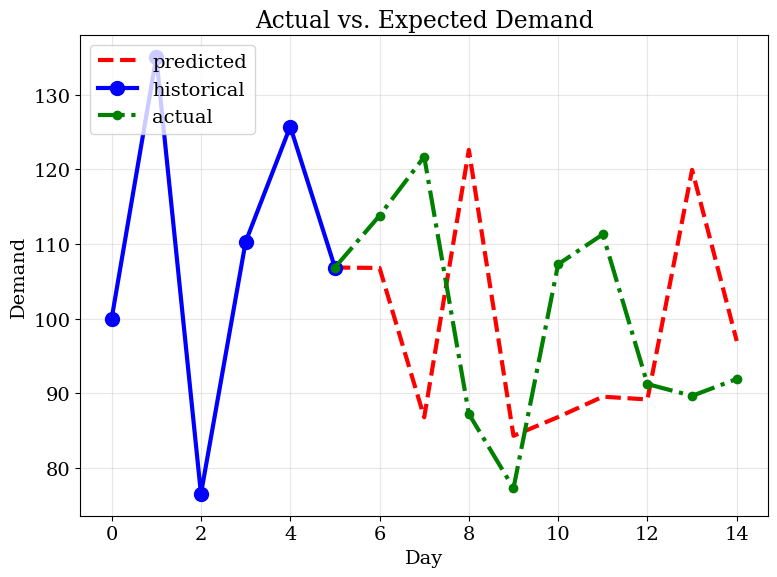

In [38]:
# rc('font', **{'family': 'serif', 'size': 14})
# 
# fig, ax = plt.subplots(figsize = (8, 6))
# x = list(range(5,15))
# # Plotting
# ax.plot(x, y, marker='', label='predicted', color = 'red', linestyle='--', linewidth = 3)  # 'o' adds circular markers at data points
# ax.plot(y1[0:6], marker='o', label='historical', color ='blue', linewidth = 3, markersize=10)
# ax.plot(x, y1[5:15], label='actual', color ='green', linewidth = 3, linestyle='-.', marker = 'o')
# plt.title('Actual vs. Expected Demand')
# plt.ylabel('Demand')
# plt.xlabel('Day')
# plt.grid(alpha = 0.3)
# ax.legend(loc='upper left')
# plt.tight_layout()
# plt.savefig(fname = 'contonly0', dpi = 300)
# plt.show()
# plt.rcdefaults()

In [39]:
close_loop_results = supply_chain_controller(time_ind=scale_iter_list, c_horizon=1, p_horizon=10, end_at=(0,26,6), design_model=load_output_dict[design_scen], eps=0.7)

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint location capex
constraint location fopex
constraint storage cost
constraint storage capex
constraint storage cost location
constraint storage cost network
constraint production mode
constraint inventory balance
constraint inventory network
constraint resource export
constraint transport export
constraint export
constraint transport capex
constraint transport network capex
constraint transport export network
constraint transport vopex
constraint transport network vopex
constraint transport fopex
constraint transport network fopex
constraint transport capacity UB no bin
constraint transport capacity LB no bin
constraint storage facility
constraint production facility
constraint min production facility
constraint min storage facility
constraint transport capacity UB
constraint transport capacity LB
constraint demand penalty
constraint demand penalty location
constraint deman

KeyboardInterrupt: 

In [ ]:
write_iis(pyomo_model=model_record[(0,10,2)], iis_file_name=f'model0_10_2', solver='gurobi')

In [53]:
# model_record[(0,9,6)].Cap_P.pprint()

In [54]:
# model_record[(0,10,2)].Exp_F['loc2','loc5','truck25',0,10,4].pprint()

In [55]:
# model_record[(0,10,2)].S['loc5','com1_sold',0,10,2].pprint()

In [56]:
# scenario_record[(0,9,6)].travel_time_dict

In [65]:
inf_start = scale_iter_list.index((0,0,0))
inf_end = scale_iter_list.index((0,10,2))

In [64]:
inf_start

0

In [66]:
inf_end

72

In [70]:
x, y = list(), list()

In [71]:
for i in range (inf_start, inf_end):
    # model_record[scale_iter_list[i]].S['loc5','com1_sold',scale_iter_list[i]].pprint()
    x.append(i)
    y.append(pyo_val(model_record[scale_iter_list[i]].S['loc5', 'com1_sold', scale_iter_list[i]]))
    # print(f"{pyo_val(model_record[scale_iter_list[i]].S['loc5', 'com1_sold', scale_iter_list[i]])}")
    

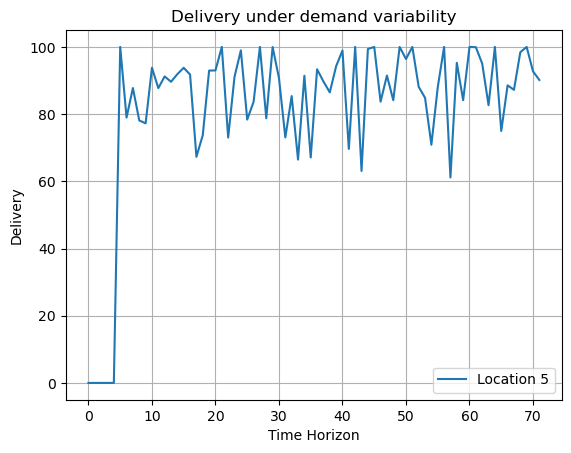

In [73]:
# x = list(range(start, len(list(value for key, value in load_results.output['S'].items() if key[0]=='loc5' and key[1]=='com1_sold'))))
# y = list(value for key, value in load_results.output['S'].items() if key[0]=='loc5' and key[1]=='com1_sold')
# y2 = [556280.48, 383540.86, 373214.82, 645751.8, 437765.47]
# Plotting
plt.plot(x, y, marker='', label='Location 5')  # 'o' adds circular markers at data points
# plt.plot(x, y2, marker='x', label='approx_obj')
plt.title('Delivery under demand variability')
plt.xlabel('Time Horizon')
plt.ylabel('Delivery')
plt.grid(True)
plt.legend()
plt.savefig(fname = 'MPC_demand_inf', dpi = 300)
plt.show()

In [ ]:
scen_final, model_final = build_schedule_model(start_time=list(results_record.keys())[0], end_time=list(results_record.keys())[-1], scen_df=pandas.DataFrame(data={('loc5', 'com1_sold'):norm_demand_dict[list(norm_demand_dict.keys())[-1]]}))

In [ ]:
plot_scenario.demand_factor(scenario=scen_final, resource='com1_sold', location='loc5')

In [ ]:
# Fix variables in model2 to the values from model1
states = ['P', 'B', 'C', 'S', 'R', 'Inv', 'P_m', 'P_material_m', 'Cap_P', 'Cap_S', 'Capex_process', 'Capex_storage', 'X_F', 'Cap_F', 'Exp', 'Capex_transport', 'X_P', 'X_S', 'X_P_m', 'Cap_P_m', 'X_P_mm', 'Demand_penalty', 'Demand_penalty_cost']

# states = ['P', 'B', 'C', 'S', 'R', 'Inv', 'P_m', 'P_material_m', 'Cap_P', 'Cap_S', 'X_F', 'Cap_F', 'Exp', 'X_P', 'X_S', 'X_P_m', 'Cap_P_m', 'X_P_mm', 'Demand_penalty', 'Demand_penalty_cost']
for v1 in model_record[list(model_record.keys())[-1]].component_objects(Var, active=True):
    vname = v1.name
    if vname in states:
        v2 = getattr(model_final, vname)
        for index in v1:
            # val = pyo_val(v1[index])
            if v1[index].value is not None:
                v2[index].fix(pyo_val(v1[index]))

In [ ]:
results_final = solve(scenario=scen_final, instance=model_final, solver='gurobi', name='MILP_final')

In [ ]:
# model_final.constraint_demand_penalty['loc5','com1_sold',0,0,0].pprint()

In [ ]:
# with open(f'model_final.ilp', 'rb') as f:
#     c = f.read()
# print(c)

In [ ]:
with open(f'test_results_record.pkl', 'wb') as file:
    pickle.dump(results_record[(0,3,5)], file)

In [ ]:
with open(f'test_results_record.pkl', 'rb') as file:
    load_results = pickle.load(file)

In [ ]:
type(load_results)

In [ ]:
plot_results.schedule(results=load_results, y_axis='S', component='com1_sold', location='loc5')

In [ ]:
plot_results.transport(results=load_results, source='loc1', sink='loc2', resource='com1_loc1_out', transport='truck12')